# Segmenting and Clustering Neighborhoods in Toronto with API & Map

## Introduction

In this project, I will demonstrate how to convert addresses into their equivalent latitude and longitude values. Also, I will use the **Foursquare API** to explore neighborhoods in Toronto, and use the **explore** function to get the most common venue categories in each neighborhood, and then I will use the **k-means** clustering algorithm to group the neighborhoods into clusters based on this feature. Finally, I will use the **Folium** library to visualize the neighborhoods in Toronto and their emerging clusters.

## Table of Contents

<div class="alert alert-block alert-info" style="margin-top: 20px">

<font size = 3>

1. <a href="#item1">Explore Dataset</a>

2. <a href="#item2">Explore Neighborhoods in Old City of Toronto</a>

3. <a href="#item3">Analyze Categories in each Neighborhood</a>

4. <a href="#item4">Cluster Neighborhoods</a>

5. <a href="#item5">Examine Each of the Five Clusters</a>    
</font>
</div>

Import libraries that will be used in this project

In [1]:
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

from sklearn.cluster import KMeans  # import k-means from clustering stage

import matplotlib.cm as cm   # Matplotlib and associated plotting modules
import matplotlib.colors as colors
from matplotlib import pyplot as plt

import folium # map rendering library

## 1. Explore Dataset: Get all the neighborhood names of Toronto from wikipedia

In [2]:
# wikipedia for Toronto neighbourhoods
Toronto_url = 'https://en.wikipedia.org/wiki/Demographics_of_Toronto_neighbourhoods'

In [3]:
Toronto = pd.read_clipboard()
Toronto.head()

,Name,FM,Census Tracts,Population,Land area (km2),Density (people/km2),% Change in Population since 2001,Average Income,Transit Commuting %,% Renters,Second most common language (after English) by name,Second most common language (after English) by percentage,Map
0,Port Lands,OCoT,0001.00,571,6.10,94,-9.0,"36,243",14.9,10.5,Mandarin (3.5%),03.5% Mandarin,Port Lands map.PNG
1,Toronto Islands,OCoT,0002.00,627,3.17,198,-5.0,"43,344",18.3,5.6,None (0%),0% any,NaN
2,Parkdale,OCoT,"0004.00, 0005.00, 0007.01, 0007.02, 0047.01, 0...","28,367",2.03,"13,974",-8.0,"26,314",22.2,39.0,Polish (2.9%),02.9% Polish,Parkdale Toronto map.png
3,Fort York/Liberty Village,OCoT,0008.00,"3,821",2.13,1794,126.0,"46,086",22.8,27.9,Hindi (1.7%),01.7% Hindi,Fort York map.png
4,Niagara,OCoT,0010.02,"6,524",0.55,"11,862",-4.0,"44,611",21.2,21.4,Portuguese (4.0%),04.0% Portuguese,Niagara map.PNG


For this part, I am only interested in all the neighborhood names of Toronto ('Name') and the former municipality values ('FM'). Thus, I will only keep these two features, 'Name' and 'FM'.

In [4]:
Toronto_df = Toronto[['Name', 'FM']]
Toronto_df.head()

,Name,FM
0,Port Lands,OCoT
1,Toronto Islands,OCoT
2,Parkdale,OCoT
3,Fort York/Liberty Village,OCoT
4,Niagara,OCoT


In [5]:
Toronto_df['FM'].unique()

array(['OCoT', 'Y', 'EY', 'E', 'NY', 'S'], dtype=object)

To make the data more readable, I add a new feature 'Full_FM' to include the full name for the forer municipality ('FM') values below:
- **E : Etobicoke**
- **S : Scarborough**
- **Y : York**
- **EY : East York**
- **NY : North York**
- **OCoT : Old City of Toronto**

In [11]:
# add a new variable 'Full_FM', and assign values above
Toronto_df['Full_FM'] = pd.Series(Toronto_df['FM'])
Toronto_df['Full_FM'] = Toronto_df['Full_FM'].replace({'Y':'York', 
                                                       'EY':'East York', 
                                                       'E':'Etobicoke', 
                                                       'NY':'North York', 
                                                       'S':'Scarborough', 
                                                       'OCoT':'Old City of Toronto'})

/Users/xslittlemaggie/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/xslittlemaggie/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [12]:
Toronto_df.head()

,Name,FM,Full_FM
0,Port Lands,OCoT,Old City of Toronto
1,Toronto Islands,OCoT,Old City of Toronto
2,Parkdale,OCoT,Old City of Toronto
3,Fort York/Liberty Village,OCoT,Old City of Toronto
4,Niagara,OCoT,Old City of Toronto


#### Use geopy library to get the latitude and longitude values for each of the neighborhood in Toronto.

In [13]:
for address in Toronto_df['Name']:
    geolocator = Nominatim(user_agent = 'specify_your_app_name_here')
    try:   
        location = geolocator.geocode(address)
        latitude = location.latitude
        longitude = location.longitude
    except:
        location = np.nan   # assign lat, lng with NaN if the data are not avaialbel
        latitude = np.nan
        longitude = np.nan
    #print('The geographical coordinate of', address, 'are {}, {}.'.format(latitude, longitude)) 

In [14]:
Latitude = []
Longitude = []
for address in Toronto_df['Name']:
    geolocator = Nominatim(user_agent = 'specify_your_app_name_here')
    try:   
        location = geolocator.geocode(address)
        latitude = location.latitude
        longitude = location.longitude
    except:
        location = np.nan
        latitude = np.nan
        longitude = np.nan
    Latitude.append(latitude)
    Longitude.append(longitude)
#print(Latitude)
#print(Longitude)

Now, I already got the latitude and longitude values for each of the neighborhood in Toronto. Next, I will add this two features to the dataset Toronto_df. 

In [15]:
Toronto_df['Latitude'] = pd.Series(Latitude)
Toronto_df['Longitude'] = pd.Series(Longitude)

/Users/xslittlemaggie/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/xslittlemaggie/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [16]:
Toronto_df.head()

,Name,FM,Full_FM,Latitude,Longitude
0,Port Lands,OCoT,Old City of Toronto,43.643065,-79.350601
1,Toronto Islands,OCoT,Old City of Toronto,43.616196,-79.369358
2,Parkdale,OCoT,Old City of Toronto,43.637178,-79.436004
3,Fort York/Liberty Village,OCoT,Old City of Toronto,NaN,NaN
4,Niagara,OCoT,Old City of Toronto,43.063189,-79.309809


In [17]:
# check missing values
Toronto_df.isnull().sum()

Name         0
FM           0
Full_FM      0
Latitude     8
Longitude    8
dtype: int64

There are missing values (NaN), and I will remove the rows with missing values with the below function.  

In [18]:
Toronto_df = Toronto_df.dropna()  # dropna() drop all rows that have any NaN values
Toronto_df.head()

,Name,FM,Full_FM,Latitude,Longitude
0,Port Lands,OCoT,Old City of Toronto,43.643065,-79.350601
1,Toronto Islands,OCoT,Old City of Toronto,43.616196,-79.369358
2,Parkdale,OCoT,Old City of Toronto,43.637178,-79.436004
4,Niagara,OCoT,Old City of Toronto,43.063189,-79.309809
5,Fashion District,OCoT,Old City of Toronto,43.645456,-79.394994


Check the dataset to see whether the neighborhoods with missing values are removed. 

#### Create a map of Toronto with neighborhoods superimposed on top.

In [19]:
# create map of New York using latitude and longitude values
map_Toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, FM, Name in zip(Toronto_df['Latitude'], Toronto_df['Longitude'], Toronto_df['Full_FM'], Toronto_df['Name']):
    label = '{}, {}'.format(Name, FM)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Toronto)  
    
map_Toronto

**Folium** is a great visualization library. It's available to zoom into the above map, and click on each circle mark to reveal the name of the neighborhood and its FM.

## 2. Explore Neighborhoods in Old City of Toronto

This analysis is composed of two parts:
- **Part 1**: Explore the first neighborhood in the dataframe the Old City of Toronto (OCoT).
- **Part 2**: Explore all neighborhoods in the Old City of Toronto (OCoT).

##### At the first part, I will demonstrate the details step by step of how to get the venues in the first neighborhood. At the second part, I will write a function to repeate the process for each of the neighborhood in the Cold City of Toronto, and analyze the venues of all neighborhoods in Old City of Toronto. 

Now, I will simplify the above map and segment and cluster only the neighborhoods in Old City of Toronto. So I will slice the original dataframe and create a new dataframe of the Old City of Toronto.

In [20]:
Toronto_df['Full_FM'].unique()

array(['Old City of Toronto', 'York', 'East York', 'Etobicoke',
       'North York', 'Scarborough'], dtype=object)

In [21]:
OCoT_df = Toronto_df[Toronto_df['FM'] == 'OCoT'].reset_index(drop= True)
OCoT_df.head()

,Name,FM,Full_FM,Latitude,Longitude
0,Port Lands,OCoT,Old City of Toronto,43.643065,-79.350601
1,Toronto Islands,OCoT,Old City of Toronto,43.616196,-79.369358
2,Parkdale,OCoT,Old City of Toronto,43.637178,-79.436004
3,Niagara,OCoT,Old City of Toronto,43.063189,-79.309809
4,Fashion District,OCoT,Old City of Toronto,43.645456,-79.394994


In [22]:
# create map of Old City of Toronto with latitude and longitude values
map_OCoT = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, FM, Name in zip(OCoT_df['Latitude'], OCoT_df['Longitude'], OCoT_df['Full_FM'], OCoT_df['Name']):
    label = '{}, {}'.format(Name, FM)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_OCoT)  
    
map_OCoT

Next, I am going to utilize **Foursquare API** to explore the venues of neighborhoods in Old City of Toronton, and segment them.

#### Define Foursquare Credentials and Version

In [23]:
CLIENT_ID = '20YHTHRNXTTGMZBL2VPZTY0II3WY0Q4UD3BQC2RAWFQSYROE' # my Foursquare ID
CLIENT_SECRET = 'RP5YFHFIGAV4XXIKPJRQ1SHLHDAXE1WUKRNIE3UFXFGCDWAO' # my Foursquare Secret

VERSION = '20190103' # Foursquare API version

print('My credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

My credentails:
CLIENT_ID: 20YHTHRNXTTGMZBL2VPZTY0II3WY0Q4UD3BQC2RAWFQSYROE
CLIENT_SECRET:RP5YFHFIGAV4XXIKPJRQ1SHLHDAXE1WUKRNIE3UFXFGCDWAO


### Part 1: Explore the first neighborhood in the Old City of Toronto (OCoT)

Get the first neighborhood's name

In [24]:
OCoT_df.loc[0, 'Name'] # get the information of the first row, column = 'Name'

'Port Lands'

Get the neighborhood's latitude and longitude values

In [25]:
neighborhood_latitude = OCoT_df.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = OCoT_df.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = OCoT_df.loc[0, 'Name'] # neighborhood name

print('The latitude and longitude of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

The latitude and longitude of Port Lands are 43.6430648, -79.3506012.


#### Extract the top 100 venues that are in this neighborhood within a radius of 500 meters.

##### **Step 1**: Get the url for the Foursqurae API

In [26]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?&client_id=20YHTHRNXTTGMZBL2VPZTY0II3WY0Q4UD3BQC2RAWFQSYROE&client_secret=RP5YFHFIGAV4XXIKPJRQ1SHLHDAXE1WUKRNIE3UFXFGCDWAO&v=20190103&ll=43.6430648,-79.3506012&radius=500&limit=100'

##### **Step 2**: Send the GET request and extract the information step by step

**a.** get the overal results

In [27]:
result = requests.get(url).json()
result.keys()

dict_keys(['meta', 'response'])

I can also check what we get from the result. Since it is too long, I won't print it here now.

In [28]:
#result

**b.** get the venues from the **key: response**

In [30]:
# display the informaiton for the first two venues
venues = result['response']['groups'][0]['items']
venues[0:1]

[{'reasons': {'count': 0,
   'items': [{'summary': 'This spot is popular',
     'type': 'general',
     'reasonName': 'globalInteractionReason'}]},
  'venue': {'id': '57954f2e498e85cfbae8070e',
   'name': 'Cirque du Soleil - LUZIA',
   'location': {'address': '51 Commissioners Street',
    'crossStreet': 'Cherry Street',
    'lat': 43.644790760637946,
    'lng': -79.35100021351447,
    'labeledLatLngs': [{'label': 'display',
      'lat': 43.644790760637946,
      'lng': -79.35100021351447}],
    'distance': 194,
    'cc': 'CA',
    'neighborhood': 'Port Lands',
    'city': 'Toronto',
    'state': 'ON',
    'country': 'Canada',
    'formattedAddress': ['51 Commissioners Street (Cherry Street)',
     'Toronto ON',
     'Canada']},
   'categories': [{'id': '52e81612bcbc57f1066b79e7',
     'name': 'Circus',
     'pluralName': 'Circuses',
     'shortName': 'Circus',
     'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/arts_entertainment/default_',
      'suffix': '.png'},
     'p

**c.** flatten JSON and structure it into a **pandas** dataframe.

In [31]:
nearby_venues = json_normalize(venues)
nearby_venues.head()

,reasons.count,reasons.items,referralId,venue.categories,venue.id,venue.location.address,venue.location.cc,venue.location.city,venue.location.country,venue.location.crossStreet,...,venue.location.labeledLatLngs,venue.location.lat,venue.location.lng,venue.location.neighborhood,venue.location.postalCode,venue.location.state,venue.name,venue.photos.count,venue.photos.groups,venue.venuePage.id
0,0,"[{'summary': 'This spot is popular', 'type': '...",e-0-57954f2e498e85cfbae8070e-0,"[{'id': '52e81612bcbc57f1066b79e7', 'name': 'C...",57954f2e498e85cfbae8070e,51 Commissioners Street,CA,Toronto,Canada,Cherry Street,...,"[{'label': 'display', 'lat': 43.64479076063794...",43.644791,-79.351000,Port Lands,NaN,ON,Cirque du Soleil - LUZIA,0,[],NaN
1,0,"[{'summary': 'This spot is popular', 'type': '...",e-0-4ad8f18ef964a520401621e3-1,"[{'id': '52f2ab2ebcbc57f1066b8b46', 'name': 'S...",4ad8f18ef964a520401621e3,222 Cherry St.,CA,Toronto,Canada,btwn Commissioners St. & Polson St.,...,"[{'label': 'display', 'lat': 43.64349082636327...",43.643491,-79.351526,NaN,M5A 3L2,ON,T&T Supermarket 大統華超級市場,0,[],NaN
2,0,"[{'summary': 'This spot is popular', 'type': '...",e-0-52adedf011d24be20f5c4a8f-2,"[{'id': '4f4528bc4b90abdf24c9de85', 'name': 'A...",52adedf011d24be20f5c4a8f,33 Villiers St,CA,Toronto,Canada,Villiers St. & Cherry St.,...,"[{'label': 'display', 'lat': 43.64708818241131...",43.647088,-79.351306,NaN,M5A 1A9,ON,BATLgrounds,0,[],NaN
3,0,"[{'summary': 'This spot is popular', 'type': '...",e-0-4c61f78ae1621b8d1f832253-3,"[{'id': '4bf58dd8d48988d1f4931735', 'name': 'R...",4c61f78ae1621b8d1f832253,18 Polson St,CA,Toronto,Canada,NaN,...,"[{'label': 'display', 'lat': 43.64251250706496...",43.642513,-79.351435,NaN,M5A 1A4,ON,Polson Go-karts,0,[],NaN
4,0,"[{'summary': 'This spot is popular', 'type': '...",e-0-59b1d9cc0d8a0f05289576f0-4,"[{'id': '52e81612bcbc57f1066b79e7', 'name': 'C...",59b1d9cc0d8a0f05289576f0,51 commissioner st.,CA,Toronto,Canada,NaN,...,"[{'label': 'display', 'lat': 43.64499835363828...",43.644998,-79.351213,NaN,NaN,ON,Cirque Du Soleil - Volta,0,[],NaN


**d.** filter columns, extract the columns (or features) of interested, **'venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng'**

In [32]:
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

In [33]:
nearby_venues.head()

,venue.name,venue.categories,venue.location.lat,venue.location.lng
0,Cirque du Soleil - LUZIA,"[{'id': '52e81612bcbc57f1066b79e7', 'name': 'C...",43.644791,-79.351000
1,T&T Supermarket 大統華超級市場,"[{'id': '52f2ab2ebcbc57f1066b8b46', 'name': 'S...",43.643491,-79.351526
2,BATLgrounds,"[{'id': '4f4528bc4b90abdf24c9de85', 'name': 'A...",43.647088,-79.351306
3,Polson Go-karts,"[{'id': '4bf58dd8d48988d1f4931735', 'name': 'R...",43.642513,-79.351435
4,Cirque Du Soleil - Volta,"[{'id': '52e81612bcbc57f1066b79e7', 'name': 'C...",43.644998,-79.351213


**e.** clear the **venue.categories**, extract the **name** from categories

Take the first venue as the example, extract the **name** from the categories

In [34]:
first_venue_cat = nearby_venues.loc[0, 'venue.categories']
first_venue_cat

[{'id': '52e81612bcbc57f1066b79e7',
  'name': 'Circus',
  'pluralName': 'Circuses',
  'shortName': 'Circus',
  'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/arts_entertainment/default_',
   'suffix': '.png'},
  'primary': True}]

The **venue.categories** is a list with one dict

In [35]:
first_venue_cat[0]['name']

'Circus'

Create a new feature with the **category.name** values only for all venues

In [36]:
nearby_venues['category'] = [v[0]['name'] for v in nearby_venues['venue.categories']]
nearby_venues.head()

,venue.name,venue.categories,venue.location.lat,venue.location.lng,category
0,Cirque du Soleil - LUZIA,"[{'id': '52e81612bcbc57f1066b79e7', 'name': 'C...",43.644791,-79.351000,Circus
1,T&T Supermarket 大統華超級市場,"[{'id': '52f2ab2ebcbc57f1066b8b46', 'name': 'S...",43.643491,-79.351526,Supermarket
2,BATLgrounds,"[{'id': '4f4528bc4b90abdf24c9de85', 'name': 'A...",43.647088,-79.351306,Athletics & Sports
3,Polson Go-karts,"[{'id': '4bf58dd8d48988d1f4931735', 'name': 'R...",43.642513,-79.351435,Racetrack
4,Cirque Du Soleil - Volta,"[{'id': '52e81612bcbc57f1066b79e7', 'name': 'C...",43.644998,-79.351213,Circus


**f.** clear the columns, ane remove the unnecessary column **venue.categories**

In [37]:
nearby_venues.rename(columns = {'venue.name':'name', 'venue.location.lat':'lat', 'venue.location.lng':'lng'}, inplace = True)

In [38]:
nearby_venues.drop(['venue.categories'], axis = 1, inplace = True)

In [39]:
# change the orders of the columns
column_order = ['name', 'category', 'lat', 'lng']
nearby_venues[column_order].head()

,name,category,lat,lng
0,Cirque du Soleil - LUZIA,Circus,43.644791,-79.351000
1,T&T Supermarket 大統華超級市場,Supermarket,43.643491,-79.351526
2,BATLgrounds,Athletics & Sports,43.647088,-79.351306
3,Polson Go-karts,Racetrack,43.642513,-79.351435
4,Cirque Du Soleil - Volta,Circus,43.644998,-79.351213


Alternative method to rename the columns

In [40]:
#earby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

In [41]:
# create map of the venues from the first neighborhood in Old City of Toronto using latitude and longitude values
map_first_OCoT = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, category, Name in zip(nearby_venues['lat'], nearby_venues['lng'], nearby_venues['category'], nearby_venues['name']):
    label = '{}, {}'.format(Name, category)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='green',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_first_OCoT)  
    
map_first_OCoT

### Part 2. Explore all neighborhoods in Old City of Toronto (OCoT)

For each neighborhood in Old City of Toronton, find the venues within radius = 500. 

Review the dataset OCoT_df

In [42]:
OCoT_df.head()

,Name,FM,Full_FM,Latitude,Longitude
0,Port Lands,OCoT,Old City of Toronto,43.643065,-79.350601
1,Toronto Islands,OCoT,Old City of Toronto,43.616196,-79.369358
2,Parkdale,OCoT,Old City of Toronto,43.637178,-79.436004
3,Niagara,OCoT,Old City of Toronto,43.063189,-79.309809
4,Fashion District,OCoT,Old City of Toronto,43.645456,-79.394994


#### Create a function to repeat the same process to get the venues of all neighborhoods in Old City of Toronto

In [43]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):

    venues_list=[]

    # use loop function to visit each of the neighborhood in Toronto, to get the lat, lng
    for name, lat, lng in zip(names, latitudes, longitudes):

        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
                    CLIENT_ID, 
                    CLIENT_SECRET, 
                    VERSION, 
                    lat, 
                    lng, 
                    radius, 
                    LIMIT)
        # print(url)

        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']

        # acquire the relevant information for each nearby venue
        venues_list.append([(name, lat, lng,
          v['venue']['name'], 
          v['venue']['location']['lat'],
          v['venue']['location']['lng'], 
          v['venue']['categories'][0]['name']) for v in results])


        # create dataframe for the venues_list
        nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list]) 

        # add column names
        nearby_venues.columns = ['Neighborhood', 
                      'Neighborhood Latitude', 
                      'Neighborhood Longitude', 
                      'Venue', 
                      'Venue Latitude', 
                      'Venue Longitude', 
                      'Venue Category']
    
    return nearby_venues

In [44]:
OCoT_venues = getNearbyVenues(OCoT_df['Name'], OCoT_df['Latitude'], OCoT_df['Longitude'])
OCoT_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Port Lands,43.643065,-79.350601,Cirque du Soleil - LUZIA,43.644791,-79.351000,Circus
1,Port Lands,43.643065,-79.350601,T&T Supermarket 大統華超級市場,43.643491,-79.351526,Supermarket
2,Port Lands,43.643065,-79.350601,BATLgrounds,43.647088,-79.351306,Athletics & Sports
3,Port Lands,43.643065,-79.350601,Polson Go-karts,43.642513,-79.351435,Racetrack
4,Port Lands,43.643065,-79.350601,Cirque Du Soleil - Volta,43.644998,-79.351213,Circus


#### Get the counts of venues in each of the neighborhood in Old City of Toronto

In [45]:
venue_count = OCoT_venues['Neighborhood'].value_counts()
venue_count.head(10)

Kensington Market           100
Fashion District            100
Yorkville                   100
Financial District          100
Alexandra Park              100
Church and Wellesley         93
Harbourfront / CityPlace     82
Discovery District           79
Little Italy                 66
Dufferin Grove               57
Name: Neighborhood, dtype: int64

#### Find out how many unique categories can be curated from all the returned venues

In [46]:
print('There are {} uniques categories.'.format(len(OCoT_venues['Venue Category'].unique())))
print('The categories are: ', OCoT_venues['Venue Category'].unique()[0:5], ', etc.')

There are 274 uniques categories.
The categories are:  ['Circus' 'Supermarket' 'Athletics & Sports' 'Racetrack' 'Nightclub'] , etc.


#### Get the 20 most common categories in Old City of Toronto

In [47]:
Most_common_cat = OCoT_venues['Venue Category'].value_counts()
top_20_cat = Most_common_cat[0:20]
top_20_cat

Coffee Shop            129
Café                    93
Bar                     64
Italian Restaurant      61
Restaurant              58
Bakery                  49
Pizza Place             45
Sandwich Place          37
Park                    36
Grocery Store           35
Sushi Restaurant        33
Pub                     29
Japanese Restaurant     27
Indian Restaurant       26
Hotel                   26
Diner                   25
American Restaurant     24
Gym                     24
Breakfast Spot          22
Ice Cream Shop          22
Name: Venue Category, dtype: int64

#### Visualization of the top 20 categories in Old City of Toronto

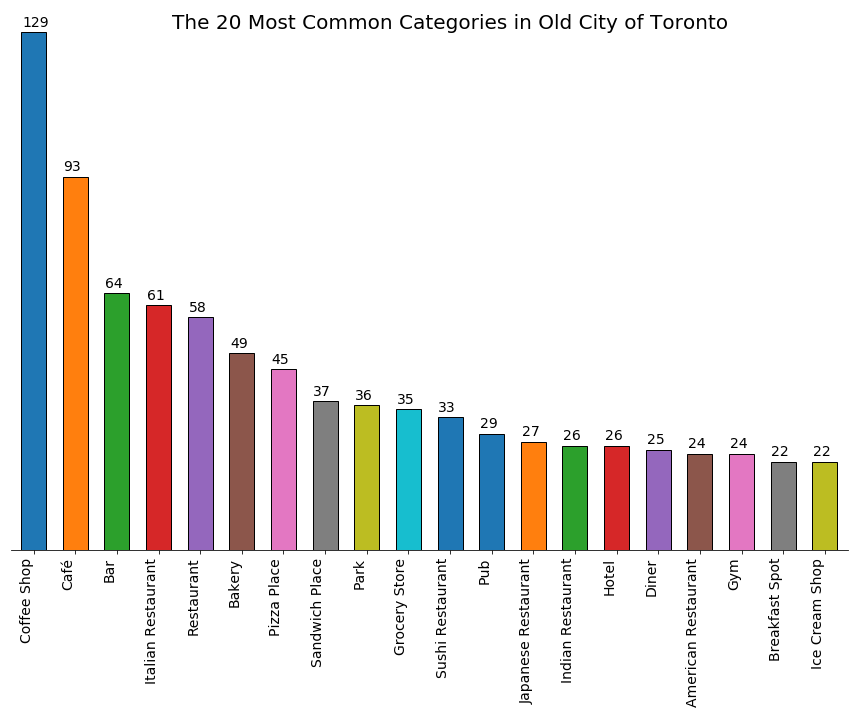

In [48]:
ax = top_20_cat.plot(kind= 'bar',
                                edgecolor = 'black',
                                figsize = (15, 10),
                                width = 0.6)
figure_title = 'The 20 Most Common Categories in Old City of Toronto'
#ax.set_title('The 20 Most Common Categories in Old City of Toronto', fontsize = 16)  # could edit the position of the title (loc='left', 'center', 'right')
plt.text(10, 130, figure_title,
         horizontalalignment='center',
         fontsize=20)
ax.set_xticklabels(top_20_cat.index, rotation = 90, ha = 'right', fontsize = 14)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.axes.get_yaxis().set_visible(False)

#for i in range(0, len(top_20_cat)):
for index, value in enumerate(top_20_cat):
    labels = value
    plt.annotate(labels,
                 xy = (index - 0.28, value + 1.55), 
                 color = 'black',
                 fontsize = 14)

From the figure above, the 'Coffee Shop' is the top 1 common venue categories among the neighborhoods in Old City of Toronto.

## 3. Analyze Categories in each Neighborhood 

At this part, the frequency of each category will be analyzed to explore the characteristics of each neighborhood in Old City of Toronto. 

In [49]:
OCoT_venues[['Venue Category']].head(5)

,Venue Category
0,Circus
1,Supermarket
2,Athletics & Sports
3,Racetrack
4,Circus


In [50]:
# convert each of the venue category into column by utilizing dummies
OCoT_onehot = pd.get_dummies(OCoT_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhoods column back to dataframe
OCoT_onehot['Neighborhoods'] = OCoT_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [OCoT_onehot.columns[-1]] + list(OCoT_onehot.columns[:-1])
OCoT_onehot = OCoT_onehot[fixed_columns]

OCoT_onehot.head()

,Neighborhoods,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,American Restaurant,Animal Shelter,Antique Shop,Arcade,Arepa Restaurant,...,Video Store,Vietnamese Restaurant,Warehouse Store,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Port Lands,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Port Lands,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Port Lands,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Port Lands,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Port Lands,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Examine the size for the new dataframe size, it should be 275 columns (274 dummies + neighborhood)

In [51]:
OCoT_onehot.shape

(1969, 275)

#### Group rows by neighborhood and take the mean of the frequency of occurrence of each category

In [52]:
OCoT_grouped = OCoT_onehot.groupby('Neighborhoods').mean().reset_index()
OCoT_grouped.head()

,Neighborhoods,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,American Restaurant,Animal Shelter,Antique Shop,Arcade,Arepa Restaurant,...,Video Store,Vietnamese Restaurant,Warehouse Store,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Alexandra Park,0.0,0.0,0.0,0.0,0.01,0.0,0.0,0.01,0.02,...,0.0,0.0,0.000000,0.0,0.0,0.01,0.0,0.0,0.0,0.01
1,Bay Street Corridor,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.00,...,0.0,0.0,0.000000,0.0,0.0,0.00,0.0,0.0,0.0,0.00
2,Bedford Park,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.00,...,0.0,0.0,0.000000,0.0,0.0,0.00,0.0,0.0,0.0,0.00
3,Bloor West Village,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.00,...,0.0,0.0,0.000000,0.0,0.0,0.00,0.0,0.0,0.0,0.00
4,Bracondale Hill,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.00,...,0.0,0.0,0.047619,0.0,0.0,0.00,0.0,0.0,0.0,0.00


The dataset **OCoT_grouped** contains the frequency of each of the 274 venue categories for each neighborhood in Old City of Toronto. Next, I will explore the most frequent venue categories for each neighborhood.

#### Confirm the new size

In [53]:
OCoT_grouped.shape

(58, 275)

#### Print each neighborhood along with the top 5 most common venues

In [54]:
num_top_venues = 5
for hood in OCoT_grouped['Neighborhoods']:
    print("-------"+hood+"-------")
    temp = OCoT_grouped[OCoT_grouped['Neighborhoods'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.loc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values(by = ['freq'], ascending=False).reset_index(drop=True).head(num_top_venues))
#    print("")
    print('\n')

-------Alexandra Park-------
                           venue  freq
0                            Bar  0.10
1                           Café  0.05
2             Italian Restaurant  0.05
3  Vegetarian / Vegan Restaurant  0.03
4         Furniture / Home Store  0.03


-------Bay Street Corridor-------
                  venue  freq
0        Sandwich Place  0.12
1                  Café  0.12
2           Coffee Shop  0.12
3  Fast Food Restaurant  0.06
4       Thai Restaurant  0.06


-------Bedford Park-------
                        venue  freq
0  Construction & Landscaping   0.5
1        Gym / Fitness Center   0.5
2           Outdoor Sculpture   0.0
3             Organic Grocery   0.0
4                Optical Shop   0.0


-------Bloor West Village-------
              venue  freq
0       Coffee Shop  0.10
1              Café  0.08
2             Diner  0.05
3       Pizza Place  0.05
4  Sushi Restaurant  0.05


-------Bracondale Hill-------
                venue  freq
0  Chinese Restaurant  0.

#### Put the neighborhood along with the top 5 most common venues into a *pandas* dataframe

First, write a function to sort the venues in descending order.

In [55]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [56]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhoods']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhoods'] = OCoT_grouped['Neighborhoods']

for ind in np.arange(OCoT_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(OCoT_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhoods,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Alexandra Park,Bar,Italian Restaurant,Café,Vegetarian / Vegan Restaurant,Restaurant,Furniture / Home Store,Coffee Shop,Dessert Shop,Nightclub,Filipino Restaurant
1,Bay Street Corridor,Sandwich Place,Café,Coffee Shop,Pharmacy,Grocery Store,Fast Food Restaurant,Liquor Store,Bus Stop,Bank,Donut Shop
2,Bedford Park,Construction & Landscaping,Gym / Fitness Center,Dog Run,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Exhibit
3,Bloor West Village,Coffee Shop,Café,Sushi Restaurant,Diner,Pizza Place,Food,Scenic Lookout,Latin American Restaurant,French Restaurant,Pub
4,Bracondale Hill,Chinese Restaurant,Restaurant,Pub,Coffee Shop,Soccer Field,Convenience Store,Café,Rock Club,Mobile Phone Shop,Baby Store


In [57]:
neighborhoods_venues_sorted['1st Most Common Venue'].value_counts()[0:3]

Coffee Shop           12
Café                   4
Italian Restaurant     4
Name: 1st Most Common Venue, dtype: int64

In [58]:
neighborhoods_venues_sorted['2nd Most Common Venue'].value_counts()[0:3]

Coffee Shop    8
Café           5
Bar            4
Name: 2nd Most Common Venue, dtype: int64

In [59]:
neighborhoods_venues_sorted['3rd Most Common Venue'].value_counts()[0:3]

Coffee Shop          5
Café                 4
Indian Restaurant    4
Name: 3rd Most Common Venue, dtype: int64

From the output above, the 'Coffee Shop' counts first for the first 3 most common venue categories.

## 4. Cluster Neighborhoods

Run *k*-means to cluster the neighborhood in Old City of Toronto into 5 clusters.

In [60]:
# set number of clusters
kclusters = 5

OCoT_grouped_clustering = OCoT_grouped.drop('Neighborhoods', axis = 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(OCoT_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

Now the neighborhoods are clustered into five groups based on their characterisitcs, the frequency of the venue categories here. 

Create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [61]:
OCoT_merged = OCoT_df

# add clustering labels
OCoT_merged['Cluster Labels'] = pd.Series(kmeans.labels_)

# merge OCoT_grouped with OCoT_df to add latitude/longitude for each neighborhood
OCoT_merged = OCoT_merged.join(neighborhoods_venues_sorted.set_index('Neighborhoods'), on='Name')

OCoT_merged.head() # check the last columns!

,Name,FM,Full_FM,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Port Lands,OCoT,Old City of Toronto,43.643065,-79.350601,0.0,Music Venue,Harbor / Marina,Circus,Racetrack,Pool,Supermarket,Theater,BBQ Joint,Athletics & Sports,Golf Driving Range
1,Toronto Islands,OCoT,Old City of Toronto,43.616196,-79.369358,0.0,Beer Garden,Scenic Lookout,American Restaurant,Beach,Farm,Yoga Studio,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space
2,Parkdale,OCoT,Old City of Toronto,43.637178,-79.436004,0.0,Tibetan Restaurant,Café,Diner,Pizza Place,Bar,Indian Restaurant,Pharmacy,Lake,Bank,Gastropub
3,Niagara,OCoT,Old City of Toronto,43.063189,-79.309809,0.0,Farm,Yoga Studio,Exhibit,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant
4,Fashion District,OCoT,Old City of Toronto,43.645456,-79.394994,0.0,Restaurant,Coffee Shop,Italian Restaurant,Sandwich Place,French Restaurant,Hotel,Beer Bar,Steakhouse,Bar,Speakeasy


In [62]:
# drop the missing values
OCoT_merged = OCoT_merged.dropna()

In [63]:
# convert the labels into integer
OCoT_merged['Cluster Labels'] = OCoT_merged['Cluster Labels'].astype(int)

Finally, let's visualize the resulting clusters

In [64]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(OCoT_merged['Latitude'], OCoT_merged['Longitude'], OCoT_merged['Name'], OCoT_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## 5. Examine Each of the Five Clusters

Now, you can examine each cluster and determine the discriminating venue categories that distinguish each cluster. Based on the defining categories, you can then assign a name to each cluster. I will leave this exercise to you.

#### Cluster 1

In [65]:
grp_1 = OCoT_merged.loc[OCoT_merged['Cluster Labels'] == 0, OCoT_merged.columns[[0] + list(range(6, OCoT_merged.shape[1]))]]
grp_1.head()

,Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Port Lands,Music Venue,Harbor / Marina,Circus,Racetrack,Pool,Supermarket,Theater,BBQ Joint,Athletics & Sports,Golf Driving Range
1,Toronto Islands,Beer Garden,Scenic Lookout,American Restaurant,Beach,Farm,Yoga Studio,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space
2,Parkdale,Tibetan Restaurant,Café,Diner,Pizza Place,Bar,Indian Restaurant,Pharmacy,Lake,Bank,Gastropub
3,Niagara,Farm,Yoga Studio,Exhibit,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant
4,Fashion District,Restaurant,Coffee Shop,Italian Restaurant,Sandwich Place,French Restaurant,Hotel,Beer Bar,Steakhouse,Bar,Speakeasy


#### Cluster 2

In [66]:
grp_2 = OCoT_merged.loc[OCoT_merged['Cluster Labels'] == 1, OCoT_merged.columns[[0] + list(range(6, OCoT_merged.shape[1]))]]
grp_2

,Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
28,Cabbagetown,Restaurant,Café,Indian Restaurant,Coffee Shop,Italian Restaurant,Diner,Beer Store,Pizza Place,Bakery,Japanese Restaurant


#### Cluster 3

In [67]:
grp_3 = OCoT_merged.loc[OCoT_merged['Cluster Labels'] == 2, OCoT_merged.columns[[0] + list(range(6, OCoT_merged.shape[1]))]]
grp_3

,Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
37,Wallace Emerson,Coffee Shop,Pharmacy,Portuguese Restaurant,Supermarket,Gym,Bank,Bakery,Skating Rink,Bar,Discount Store


#### Cluster 4

In [68]:
grp_4 = OCoT_merged.loc[OCoT_merged['Cluster Labels'] == 3, OCoT_merged.columns[[0] + list(range(6, OCoT_merged.shape[1]))]]
grp_4

,Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
56,Lytton Park,Playground,Restaurant,Garden,Dive Bar,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant


#### Cluster 5

In [69]:
grp_5 = OCoT_merged.loc[OCoT_merged['Cluster Labels'] == 4, OCoT_merged.columns[[0] + list(range(6, OCoT_merged.shape[1]))]]
grp_5

,Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
46,Bracondale Hill,Chinese Restaurant,Restaurant,Pub,Coffee Shop,Soccer Field,Convenience Store,Café,Rock Club,Mobile Phone Shop,Baby Store


#### Find the most common venue category for each of the five cluster groups

In [70]:
grp_1_most = grp_1['1st Most Common Venue'].value_counts()[0:1]
grp_1_most

Coffee Shop    10
Name: 1st Most Common Venue, dtype: int64

In [71]:
grp_2_most = grp_2['1st Most Common Venue'].value_counts()[0:1]
grp_2_most

Restaurant    1
Name: 1st Most Common Venue, dtype: int64

In [72]:
grp_3_most = grp_3['1st Most Common Venue'].value_counts()[0:1]
grp_3_most

Coffee Shop    1
Name: 1st Most Common Venue, dtype: int64

In [73]:
grp_4_most = grp_4['1st Most Common Venue'].value_counts()[0:1]
grp_4_most

Playground    1
Name: 1st Most Common Venue, dtype: int64

In [74]:
grp_5_most = grp_5['1st Most Common Venue'].value_counts()[0:1]
grp_5_most

Chinese Restaurant    1
Name: 1st Most Common Venue, dtype: int64

Create a new dataset contain the most common venue category for each of the five clusters.

In [75]:
grp_most_common = pd.DataFrame({'Groups': ['grp_1', 'grp_2', 'grp_3', 'grp_4', 'grp_5'],
                               'Most Common Venue': ['Coffee Shop', 'Cocktail Bar', 'Event Space', 'Beach', 'Bakery'],
                                'Frequency': [12, 1, 1, 1, 1]})
grp_most_common

,Groups,Most Common Venue,Frequency
0,grp_1,Coffee Shop,12
1,grp_2,Cocktail Bar,1
2,grp_3,Event Space,1
3,grp_4,Beach,1
4,grp_5,Bakery,1


From the output above, the most common for each of the five cluster groups varied a lot, may indicating some of people's living habits in the particular neighborhood. 